# ML 2 : Projet IA — Classification d'images (Enfant / Adulte / Âgé)
- Images dans `Projet ML 2/train`, `valid`, `test` 
- Redimensionnement 128×128 + normalisation
- Extraction HOG + histogrammes de couleur 
- Modèles : KNN, Arbre, Naive Bay  
- Évaluation : accuracy + matrice de confusion  

> Chaque dossier contient les images et `_clases.csv`

In [1]:
# Importations
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

from skimage.feature import hog
from skimage.color import rgb2gray

SEED = 42
np.random.seed(SEED)

IMG_SIZE = (128, 128)
DATA_DIR = "Projet ML 2"
OUTPUT_DIR = "outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("Imports et dossiers prêts")

Imports et dossiers prêts


## Structure


In [2]:

def check_split(split_name):
    split_path = os.path.join(DATA_DIR, split_name)
    images_path = os.path.join(split_path)
    labels_path = os.path.join(split_path, "_classes.csv")
    print(f"--- {split_name.upper()} ---")
    print("Images folder:", images_path, "➜➜➜➜", os.path.isdir(images_path))
    print("_classes.csv:", labels_path, "➜➜➜➜", os.path.isfile(labels_path))

for s in ["train", "valid", "test"]:
    check_split(s)


--- TRAIN ---
Images folder: Projet ML 2\train ➜➜➜➜ True
_classes.csv: Projet ML 2\train\_classes.csv ➜➜➜➜ True
--- VALID ---
Images folder: Projet ML 2\valid ➜➜➜➜ True
_classes.csv: Projet ML 2\valid\_classes.csv ➜➜➜➜ True
--- TEST ---
Images folder: Projet ML 2\test ➜➜➜➜ True
_classes.csv: Projet ML 2\test\_classes.csv ➜➜➜➜ True


## Chargement des images et création des labels :

- Lire le fichier `_classes.csv` de chaque split (train, valid, test)  
- Transformer les colonnes multi-label en une seule étiquette (`child`, `adult`, `elderly`)  
- Redimensionner chaque image en 128×128 et normaliser les pixels entre 0 niques
 et 1


In [3]:
def read_labels_csv(split_name):
    # Ici Roboflow met tout dans _classes.csv
    labels_path = os.path.join(DATA_DIR, split_name, "_classes.csv")
    df = pd.read_csv(labels_path)
    return df


def label_rule(row):
    if row["child"] == 1:
        return "child"
    elif row["adult"] == 1:
        return "adult"
    else:
        return "elderly"



def load_images_from_split(split_name, img_size=(128, 128), max_images=None):
    df = read_labels_csv(split_name)


    # Transformer multi-label -> single-label propre
    df["label"] = df.apply(label_rule, axis=1)

    # Optionnel : limiter le nombre d'images
    if max_images is not None:
        df = df.sample(min(max_images, len(df)), random_state=SEED).reset_index(drop=True)

    split_path = os.path.join(DATA_DIR, split_name)

    X = []
    y_text = []

    for _, row in df.iterrows():
        fname = str(row["filename"])
        label = str(row["label"]).strip()

        fpath = os.path.join(split_path, fname)
        if not os.path.isfile(fpath):
            continue

        img = Image.open(fpath).convert("RGB")
        img = img.resize(img_size)
        arr = np.asarray(img, dtype=np.float32) / 255.0

        X.append(arr)
        y_text.append(label)

    return np.array(X, dtype=np.float32), np.array(y_text)


# Chargement complet
X_train_img, y_train_text = load_images_from_split("train", IMG_SIZE)
X_val_img, y_val_text = load_images_from_split("valid", IMG_SIZE)
X_test_img, y_test_text = load_images_from_split("test", IMG_SIZE)

print("Train:", X_train_img.shape, y_train_text.shape)
print("Valid:", X_val_img.shape, y_val_text.shape)
print("Test :", X_test_img.shape, y_test_text.shape)

labels_uniques = sorted(set(y_train_text) | set(y_val_text) | set(y_test_text))
print("Labels uniques:", labels_uniques)


Train: (3276, 128, 128, 3) (3276,)
Valid: (315, 128, 128, 3) (315,)
Test : (158, 128, 128, 3) (158,)
Labels uniques: [np.str_('adult'), np.str_('child'), np.str_('elderly')]


## Encodage :

In [4]:

CLASS_NAMES = sorted(set(y_train_text) | set(y_val_text) | set(y_test_text))
LABEL_MAP = {name: idx for idx, name in enumerate(CLASS_NAMES)}

def encode_labels(y_text):
    return np.array([LABEL_MAP[v] for v in y_text], dtype=np.int64)

y_train = encode_labels(y_train_text)
y_val = encode_labels(y_val_text)
y_test = encode_labels(y_test_text)

print("Mapping:", LABEL_MAP)


Mapping: {np.str_('adult'): 0, np.str_('child'): 1, np.str_('elderly'): 2}


## Visualisation :

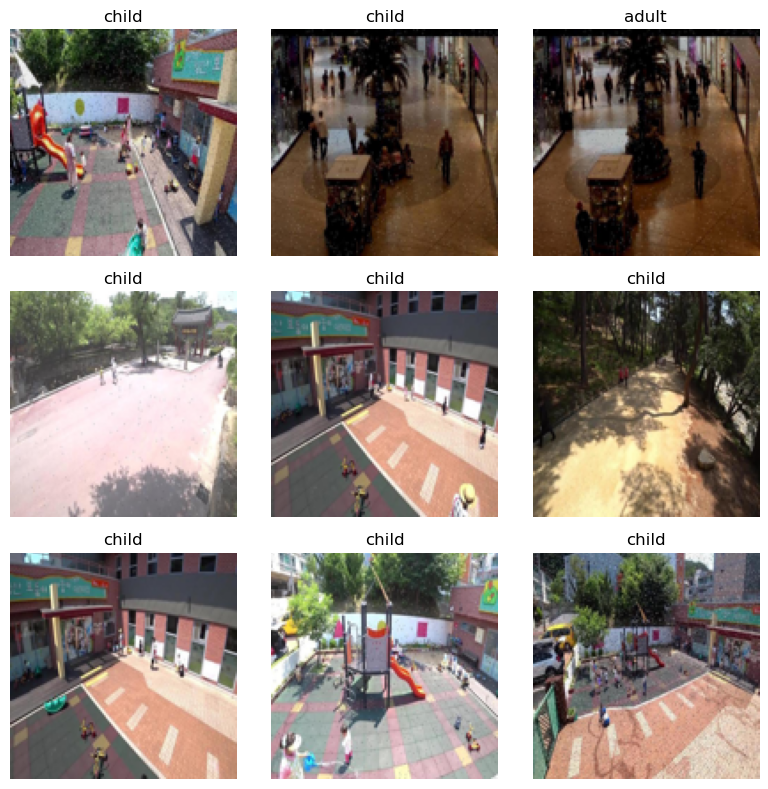

In [5]:

def show_samples(X, y, n=9):
    plt.figure(figsize=(8, 8))
    idx = np.random.choice(len(X), size=min(n, len(X)), replace=False)
    for i, j in enumerate(idx):
        plt.subplot(3, 3, i+1)
        plt.imshow(X[j])
        plt.title(CLASS_NAMES[y[j]])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_samples(X_train_img, y_train, n=9)


## Extraction des caractéristiques

- HOG pour les formes et textures
- Combinaison HOG + histogrammes pour chaque image  
- Application sur train, valid et test

In [6]:

def features_hog(img_rgb):
    img_gray = rgb2gray(img_rgb)
    feat = hog(
        img_gray,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        block_norm="L2-Hys",
        feature_vector=True
    )
    return feat.astype(np.float32)

def features_hist_couleurs(img_rgb, bins=16):
    feats = []
    for c in range(3):
        hist, _ = np.histogram(img_rgb[:, :, c], bins=bins, range=(0.0, 1.0), density=True)
        feats.append(hist)
    return np.concatenate(feats).astype(np.float32)

def extraire_features(X_images, bins_hist=16):
    feats = []
    for img in X_images:
        f_hog = features_hog(img)
        f_hist = features_hist_couleurs(img, bins=bins_hist)
        feats.append(np.concatenate([f_hog, f_hist]))
    return np.array(feats, dtype=np.float32)

X_train = extraire_features(X_train_img, bins_hist=16)
X_val   = extraire_features(X_val_img, bins_hist=16)
X_test  = extraire_features(X_test_img, bins_hist=16)

print("Features train:", X_train.shape)


Features train: (3276, 8148)


## Normalisation :

In [7]:

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s   = scaler.transform(X_val)
X_test_s  = scaler.transform(X_test)

print("Normalisation OK")


Normalisation OK


## Entraînement et évaluation :
(KNN, Arbre, Naive Bayes)

[KNN] k=3 => acc val = 0.8762
[KNN] k=5 => acc val = 0.8794
[KNN] k=7 => acc val = 0.8794
[KNN] k=9 => acc val = 0.8794

=== KNN — TEST ===
Accuracy: 0.8860759493670886
              precision    recall  f1-score   support

       adult     0.5185    0.7368    0.6087        19
       child     0.9618    0.9065    0.9333       139
     elderly     0.0000    0.0000    0.0000         0

    accuracy                         0.8861       158
   macro avg     0.4935    0.5478    0.5140       158
weighted avg     0.9085    0.8861    0.8943       158



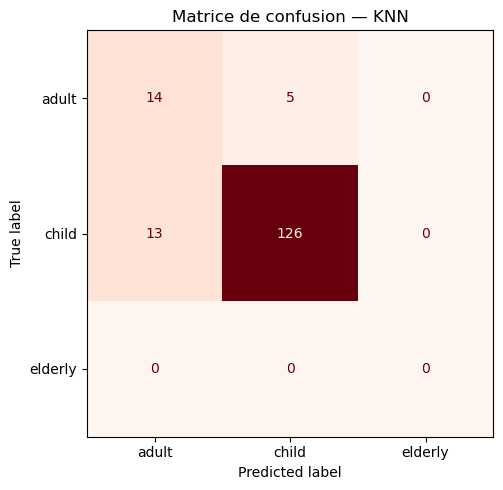

[ARBRE] crit=gini, depth=3 => acc val = 0.8317
[ARBRE] crit=gini, depth=5 => acc val = 0.8381
[ARBRE] crit=gini, depth=8 => acc val = 0.8413
[ARBRE] crit=gini, depth=None => acc val = 0.8540
[ARBRE] crit=entropy, depth=3 => acc val = 0.8381
[ARBRE] crit=entropy, depth=5 => acc val = 0.8444
[ARBRE] crit=entropy, depth=8 => acc val = 0.8349
[ARBRE] crit=entropy, depth=None => acc val = 0.8413

=== Arbre — TEST ===
Accuracy: 0.8481012658227848
              precision    recall  f1-score   support

       adult     0.4074    0.5789    0.4783        19
       child     0.9389    0.8849    0.9111       139
     elderly     0.0000    0.0000    0.0000         0

    accuracy                         0.8481       158
   macro avg     0.4488    0.4879    0.4631       158
weighted avg     0.8750    0.8481    0.8591       158



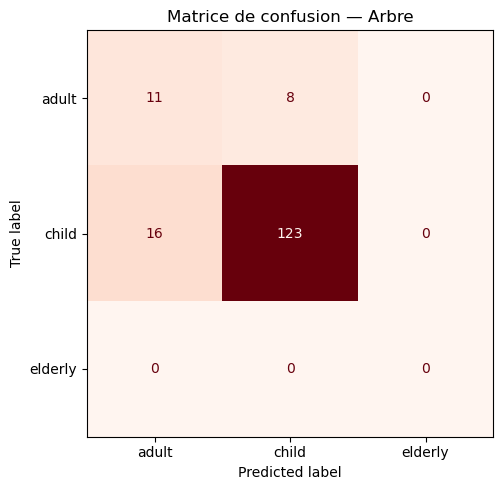

[Naive Bayes] acc val = 0.8254

=== Naive_Bayes — TEST ===
Accuracy: 0.7468354430379747
              precision    recall  f1-score   support

       adult     0.3220    1.0000    0.4872        19
       child     1.0000    0.7122    0.8319       139
     elderly     0.0000    0.0000    0.0000         0

    accuracy                         0.7468       158
   macro avg     0.4407    0.5707    0.4397       158
weighted avg     0.9185    0.7468    0.7905       158



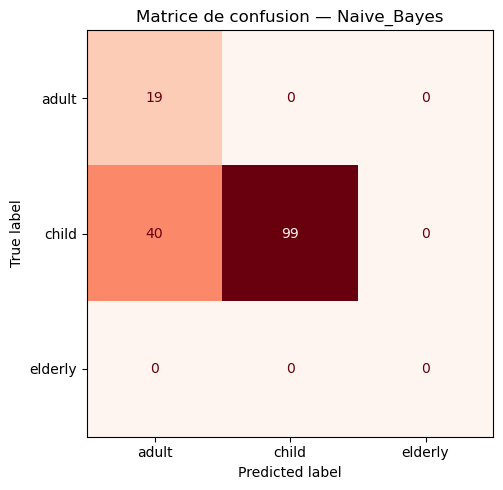


=== Résumé (accuracy TEST) ===
KNN       : 0.8860759493670886
Arbre     : 0.8481012658227848
NaiveBayes: 0.7468354430379747


In [8]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score

# Force sklearn to always include all classes
ALL_LABELS = list(range(len(CLASS_NAMES)))   # ex: [0,1,2]

def afficher_matrice_confusion(y_true, y_pred, title, save_path=None):

    cm = confusion_matrix(y_true, y_pred, labels=ALL_LABELS)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASS_NAMES)
    fig, ax = plt.subplots(figsize=(6, 5))
    disp.plot(ax=ax, cmap="Reds", colorbar=False)
    ax.set_title(title)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150)

    plt.show()


def evaluer_modele(model, X_test, y_test, nom):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    print(f"\n=== {nom} — TEST ===")
    print("Accuracy:", acc)


    print(classification_report(
        y_test, y_pred,
        labels=ALL_LABELS,
        target_names=CLASS_NAMES,
        digits=4,
        zero_division=0
    ))

    afficher_matrice_confusion(
        y_test, y_pred,
        f"Matrice de confusion — {nom}",
        save_path=os.path.join(OUTPUT_DIR, f"cm_{nom.lower().replace(' ', '_')}.png")
    )

    return acc


#  KNN : recherche simple de k
best_knn, best_val = None, -1

for k in [3, 5, 7, 9]:
    knn = KNeighborsClassifier(n_neighbors=k, metric="minkowski")
    knn.fit(X_train_s, y_train)

    val_acc = knn.score(X_val_s, y_val)
    print(f"[KNN] k={k} => acc val = {val_acc:.4f}")

    if val_acc > best_val:
        best_val = val_acc
        best_knn = knn

acc_knn = evaluer_modele(best_knn, X_test_s, y_test, "KNN")


# Arbre de décision : critère + profondeur
best_tree, best_val = None, -1

for crit in ["gini", "entropy"]:
    for depth in [3, 5, 8, None]:
        tree = DecisionTreeClassifier(
            criterion=crit,
            max_depth=depth,
            random_state=SEED
        )
        tree.fit(X_train_s, y_train)

        val_acc = tree.score(X_val_s, y_val)
        print(f"[ARBRE] crit={crit}, depth={depth} => acc val = {val_acc:.4f}")

        if val_acc > best_val:
            best_val = val_acc
            best_tree = tree

acc_tree = evaluer_modele(best_tree, X_test_s, y_test, "Arbre")

# Naive Bayes : GaussianNB
nb = GaussianNB()
nb.fit(X_train_s, y_train)

print(f"[Naive Bayes] acc val = {nb.score(X_val_s, y_val):.4f}")
acc_nb = evaluer_modele(nb, X_test_s, y_test, "Naive_Bayes")


# Résumé final
print("\n=== Résumé (accuracy TEST) ===")
print("KNN       :", acc_knn)
print("Arbre     :", acc_tree)
print("NaiveBayes:", acc_nb)
